### Pendulum: One-pfive step Method + L-BFGS

Notes:
- For some reason, the lbfgs is not leading to correct prediction for the 1.5 step method.

In [1]:
import sys
#sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
sys.path.append('/Users/yasaminjalalian/Repos/keql/source')

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from parameter_learning import * 
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize

from functools import partial # for jit to make codes faster

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from jax.config import config; 
config.update("jax_enable_x64", True)

In [4]:
model = 'pendulum'

In [5]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [6]:
two_step_dict

{'optim_sgm_u': array([6.66666667e-04, 1.33333333e+00, 6.66666667e-01]),
 'optim_nugget_u': array([1.e-14, 1.e-08, 1.e-14]),
 'rkhs_u': [0.7499999999999851, 32.59831466681769, 87.80428053411865],
 'optim_sgm_P': 0.6857990232287219,
 'optim_nugget_P': 1e-14,
 'nugget_P': 1e-07,
 'rkhs_P': 1513.56056185235,
 'f_pred_test': array([ 1.55903320e-13, -3.34275526e+01,  6.19569088e-01,  1.75716973e-13,
         8.41470787e-01,  2.09610845e+00,  4.96256175e+00,  6.90929681e+00,
         3.24319750e+00,  4.93766956e+00,  8.78894946e+00,  5.48256732e+00])}

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

In [7]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 10 
    m = 3 
    #print('Z:', Z)
    # Constrain the value of Z with known info
    #Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N*m,4))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N:(i+1)*N]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K(Gaussian, X[:N], X[:N], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot(Gaussian, X[:N], X[:N], optim_sgm, 0), alphas)
        Zi_xx = jnp.dot(K_2dot(Gaussian, X[:N], X[:N], optim_sgm, 0,0), alphas)

        Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N:(i+1)*N,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P') 
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)
    
    # First term
    L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P')
    print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N],X[:N],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N))
    
    L2 = 0.
    
    for i in range(m):
        #print('Z_constrained:', Z_warm)
        Zi = Z[i*N:(i+1)*N] # print out each of these and display the graphs here ! 
        c = jnp.linalg.solve(K_XNs[i],Zi)
        #print(K_XNs[i][:5,:5])
        #print(Zi)
        #print(Zi.shape)
        #print(c)
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i]
        print('L2_',i,':',jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i] )      
    
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [8]:
# First column in Gamma(S_N,S_N)
X = x_test_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_test.T.reshape(N*m,) # N*m * 1

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_pred_test']

Initial guess: `Z_warm`

In [9]:
# Load values of U predicted from 2-step
u_pred_test = np.load('data/u_pred_test.npy')
u_x_pred_test = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
# Build Z_warm
Z_warm = jnp.array(u_pred_test.T.reshape(N*m,)) 

In [10]:
L(Z_warm, X, U, M, f, two_step_dict, lmbd=1/3)

L1:  1.0045230155397717
L2_ 0 : 0.9999999999999899
L2_ 1 : 0.9999981241863986
L2_ 2 : 0.999999999999808


Array(2.00452239, dtype=float64)

### Optimization of L

In [11]:
# Load the warm-up
Z = np.copy(Z_warm)

In [ ]:
result = minimize(L, Z, args=(X, U, M, f, two_step_dict, 1/3), method= 'BFGS', options={'maxiter': 1000})

In [ ]:
# Optimization results
print('Optimization succeeded:',result.success)
print(result.status,': This 3 means that the zoom failed according to documentation.')
print('Final function value:',result.fun)
print('No. of iterations of the optim algorithm:',result.nit,)
print(result.jac)
print(result.hess_inv)
print(result.njev)

In [17]:
Z = result.x

In [19]:
Ztest = np.load('data/Z.npy')

> Onepfive-step Method vs Truth

In [21]:
# Build S_N - Training data
S = jnp.zeros((N*m,4))
kernel = Gaussian
# Split Z
for i in tqdm(range(m)):
    Zi = Z[i*N:(i+1)*N]
    optim_sgm , optim_lmbd = two_step_dict.get('optim_sgm_u')[i], two_step_dict.get('optim_nugget_u')[i]
    G = K(kernel, X[:N], X[:N], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N:(i+1)*N,:].set(Si)

# Load gradients from 2-step
u_x_pred_test  = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
s_test = np.hstack((x_test_all.reshape(-1,1),u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
f_test = f_Test(model,e_test)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_test)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_test) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


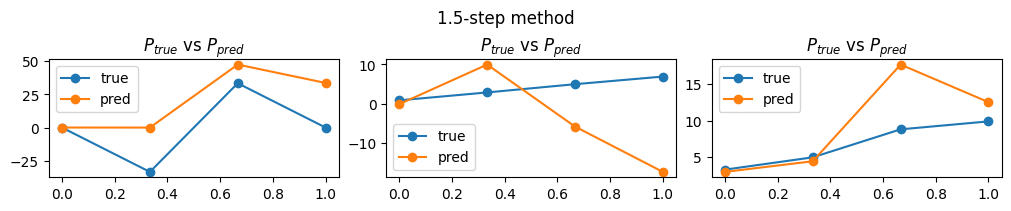

In [22]:
# Plot at testing points
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)
fig.suptitle('1.5-step method')
axs[0].plot(x_test[:e_test], f_test[:e_test] , marker= 'o', label = 'true')
axs[0].plot(x_test[:e_test], f_pred_test[:e_test], marker= 'o', label = 'pred')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')
axs[1].plot(x_test[e_test:2*e_test], f_test[e_test:2*e_test],marker= 'o', label = 'true')
axs[1].plot(x_test[e_test:2*e_test], f_pred_test[e_test:2*e_test],marker= 'o', label = 'pred')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')
axs[2].plot(x_test[2*e_test:3*e_test], f_test[2*e_test:3*e_test],marker= 'o', label = 'true')
axs[2].plot(x_test[2*e_test:3*e_test], f_pred_test[2*e_test:3*e_test],marker= 'o', label = 'pred')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()

Comment: Do a few steps with gradient descent to compute an approximation of the Hessian and use it in lbfgs. 